In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from tqdm.auto import tqdm

from models.t2t_vit import t2t_vit_14
from vit_shapley.modules.surrogate import Surrogate
from vit_shapley.CIFAR_10_Dataset import CIFAR_10_Dataset, CIFAR_10_Datamodule, PROJECT_ROOT, apply_masks_to_batch
from utils import load_state_dict

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(5)

In [2]:
datamodule = CIFAR_10_Datamodule(num_players=196, num_mask_samples=1, paired_mask_samples=False)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']

In [3]:
print(images.shape)
print(masks.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 1, 196])


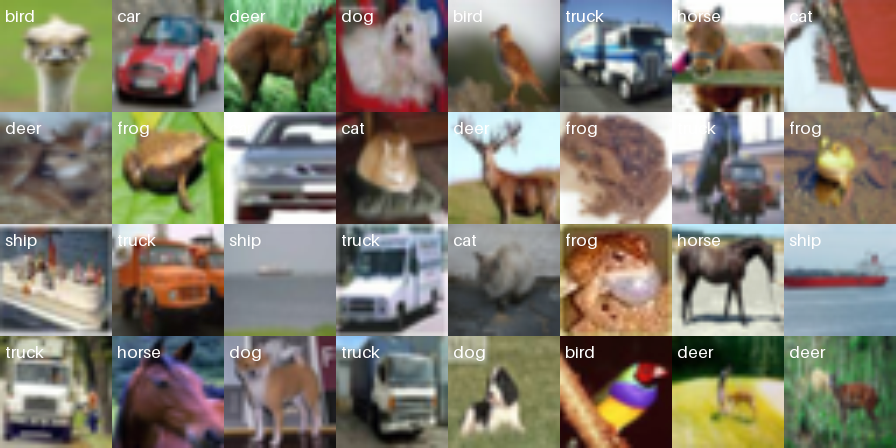

In [4]:
CIFAR_10_Dataset.to_image_grid(images, labels, scale=1/2)

<font size="12">Target model visualization</font>

In [5]:
target_model = t2t_vit_14(num_classes=10)
checkpoint = torch.load(PROJECT_ROOT / 'checkpoint_cifar10_T2t_vit_14' / 'ckpt_0.01_0.0005_97.23.pth', map_location='cuda')
checkpoint = {k.removeprefix('module.'): v for k, v in checkpoint.items()}
target_model.load_state_dict(checkpoint, strict=True)
target_model.eval()

# Predict with the model.
logits = target_model(images)
print(f'logits shape is {tuple(logits.shape)}')
preds = torch.argmax(logits, dim=1)

adopt performer encoder for tokens-to-token
logits shape is (32, 10)


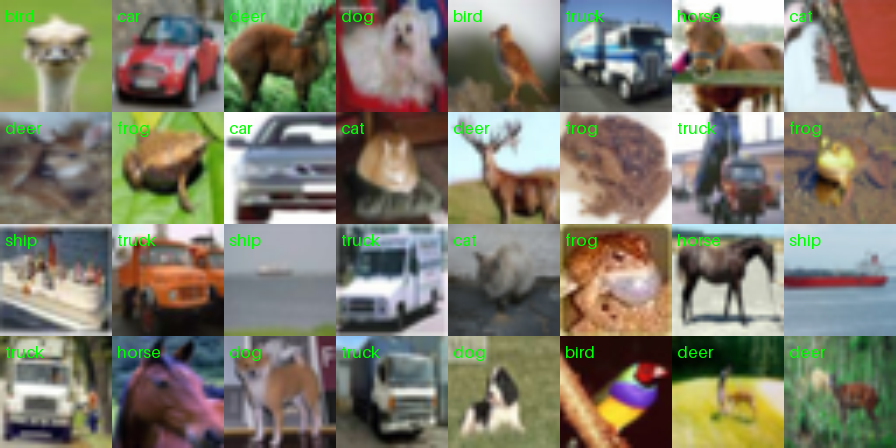

In [6]:
colors = [(0, 255, 0) if l == p else (255, 0, 0) for l, p in zip(labels, preds)]
CIFAR_10_Dataset.to_image_grid(images, preds, colors, scale=1/2)

In [7]:
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device="cuda") -> None:
    with torch.no_grad():
        model.to(device)
        correct, total = 0, 0
        progress = tqdm(dataloader)
        for d in progress:
            images, targets, masks = d['images'], d['labels'], d['masks']
            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            _, predicted = logits.max(dim=1)
            total += targets.shape[0]
            correct += predicted.eq(targets).sum().item()
            progress.set_description(f'Accuracy: {100.0 * correct / total:.2f}%')

# test(target_model, datamodule.test_dataloader(), "cuda")

<font size="12">Surrogate model visualization</font>

In [15]:
n_masks_per_image = 2
datamodule = CIFAR_10_Datamodule(num_players=196, num_mask_samples=n_masks_per_image, paired_mask_samples=True)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']

In [16]:
print(images.shape, labels.shape, masks.shape)
images_masked, labels_masked, masks_masked = apply_masks_to_batch(images, labels, masks)
print(images_masked.shape, labels_masked.shape, masks_masked.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 196])
torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64, 196])


In [17]:
surrogate = Surrogate.load_from_checkpoint(PROJECT_ROOT / "vit_shapley/modules/checkpoints_surrogate/lightning_logs/version_0/checkpoints/epoch=49-step=70350.ckpt",
                                           map_location="cuda",
                                           target_model=target_model)

surrogate.eval()
logits = surrogate(images=images.cuda(), masks=masks.cuda())
print(f'logits shape is {tuple(logits.shape)}')
preds = torch.argmax(logits, dim=1)

adopt performer encoder for tokens-to-token
logits shape is (64, 10)


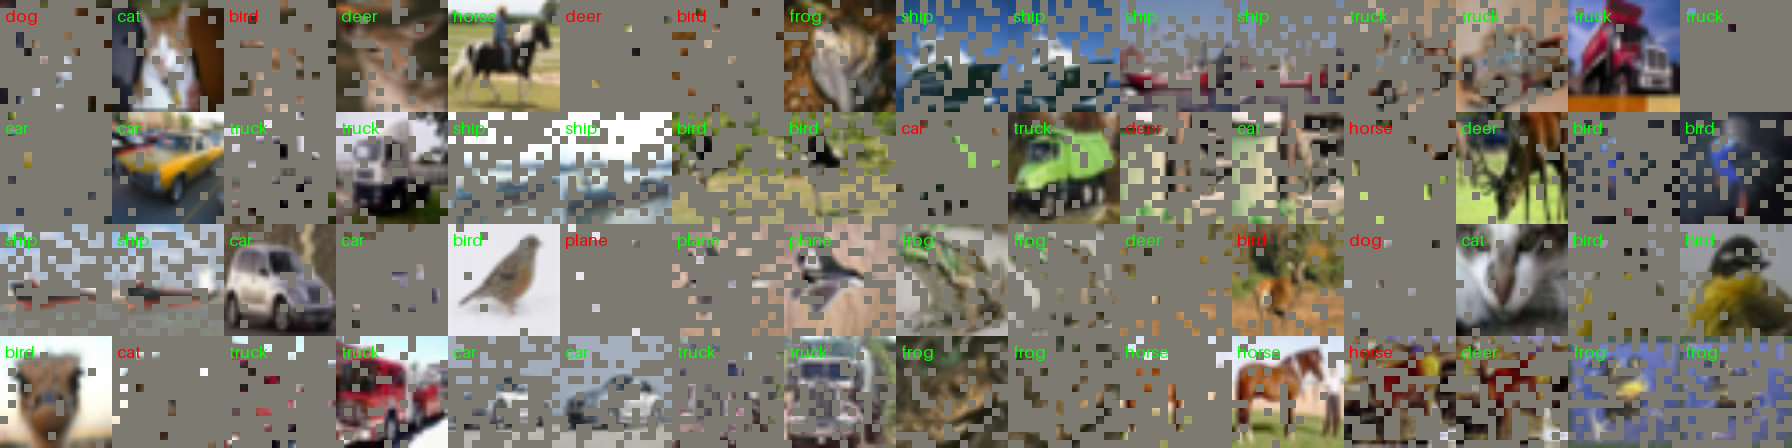

In [11]:
colors = [(0, 255, 0) if l == p else (255, 0, 0) for l, p in zip(labels_masked, preds)]
CIFAR_10_Dataset.to_image_grid(images_masked, preds, colors, scale=1/2, n_columns=n_masks_per_image * 8)

In [12]:
images = torch.zeros(64, 3, 224, 224).cuda()
masks = torch.zeros(64, 1, 196).cuda()
surrogate(images, masks).shape

torch.Size([64, 10])

In [13]:
images = torch.zeros(32, 3, 224, 224).cuda()
multiple_masks = torch.zeros(32, 2, 196).cuda()


def surrogate_multiple_masks(images, multiple_masks=None):
        """
        forward pass for embedded surrogate model.
        Args:
            images: torch.Tensor (batch, channel, height, width)
            multiple_masks: torch.Tensor (batch, num_mask_samples, num_players)

        Returns:
            surrogate_values: torch.Tensor (batch, num_mask_samples, num_classes)

        """
            # mask
        assert len(multiple_masks.shape) == 3  # (batch, num_mask_samples, num_players)
        batch_size = multiple_masks.shape[0]
        assert len(multiple_masks) == len(images)
        num_mask_samples = multiple_masks.shape[1]

        surrogate_values = torch.nn.Softmax(dim=1)(surrogate(
                images=images.repeat_interleave(num_mask_samples, dim=0),
                # (batch, channel, height, weight) -> (batch * num_mask_samples, channel, height, weight)
                masks=multiple_masks.flatten(0, 1).unsqueeze(1)
                # (batch, num_mask_samples, num_players) -> (batch * num_mask_samples, num_players)
            )).reshape(batch_size, num_mask_samples, -1)

        print(f'surrogate_values shape is {surrogate_values.shape}')

        return surrogate_values

surrogate_multiple_masks(images, multiple_masks).shape

surrogate_values shape is torch.Size([32, 2, 10])


torch.Size([32, 2, 10])